# CarND Advanced Lane Lines Finding

---

Email: felix.wf@outlook.com

Date: 2019/05/29


## Introduction

I am going to test every algorithm and method may used in the video processing while trying to finish the advanced lane lines finding project.

there will be the camera calibration, image undistortion, color and gradient threshold method for lane detection, perspective transform for top-down view and so on. Most of them are according to the code section in the lessons, and there will be some modification on the code for better display and usage.

the project is going to detect the lane lines in the video, the lane lines are more complicated than in the previous project. In this project, the lane lines are mostly curve lines, which means nearly all the methods in the previous project will be useless. 

According to the lessons, there are several steps to detect the lane lines in the videos.

- Firstly, camera calibration is needed, there are several calibration images which can be used to calibrate the camera. 

- Secondly, it's necessary to undistort every frame use the params generated while calibration the camera.

- Thirdly, use the undistorted image to detect the lane line. There are several methods can detect the lane lines, such as gradient threshold, sobel thershold, colorspace threshold and so on. In this project, I am going to use the combined threshold (color and gradient) to detect the lane lines. After that, there will be a binary image will the lane lines and also with other noise.

- 4th, Transform the binary image into a top-down view, and try to detect the left lane lines and the right lane lines with the sliding windows. At the same time, then use the curve fit function to calculate the curve with 2-order function. Here, it's a good idea to save the curve-fit functions and using on the next frame.

- 5th, Try to calculate the real radius of curve and the offset of the car and dispaly on the image

End.

There are another file named 'carND-LaneLines-P2.py', it's used for processing the videos, easier for me than in the jupyter notebook. It contains most of the code in this file.

This is all the ideas I am using on this project. To be honest, it's not easy for me to finish the challenge_video because of the time limit, there still lots of params need to be refined in the future. But time up and I have to upload my homework, I will try to do more after that.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

Here are several steps in Lesson 8, Advanced Computer Vision:

Step 1: Camera Calibration
    
    - read the images for calibration, better to be at least 20 images 
    

Step 2: Distortion Correction

    - use the params got from step 1 to distort the image

Step 3: Color & Gradient Threshold

    - test the color space threshold
    - test the gradient threshold
    - test the sobel threshold

Step 4: Perspective Transform

    - transform the image into a top-down view


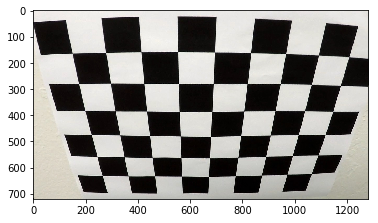

In [2]:
# Read in a calibration image and display it
img = mpimg.imread('./camera_cal/calibration2.jpg')
plt.imshow(img)

## Find corners in the chessboard
Calculate the calibration parameters from one image, find the chessboard corners and display them

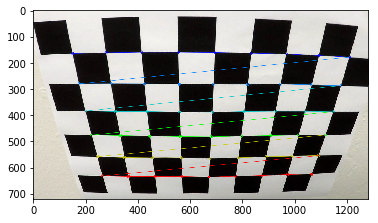

In [3]:
# Arrays to store object points and image points from all images

# 3D points in real world space
objpoints = []

# 2D points in image plane
imgpoints = []

# Prepare object points, like (0, 0, 0), (1, 0, 0) ... (7, 5, 0)
objp = np.zeros((6*9, 3), np.float32)

# Generate the x, y coordinates
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Conver image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

# If corners are found, add objecct points, image points
if ret == True:
    imgpoints.append(corners)
    objpoints.append(objp)
    
    # Draw and display the corners
    img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    plt.imshow(img)

## processing all the chessboard image and get the calibration params

Get all the chessboard and append all the objpoints and imgpoints for calibration params calculation. Finally use one image to test the result. 

True

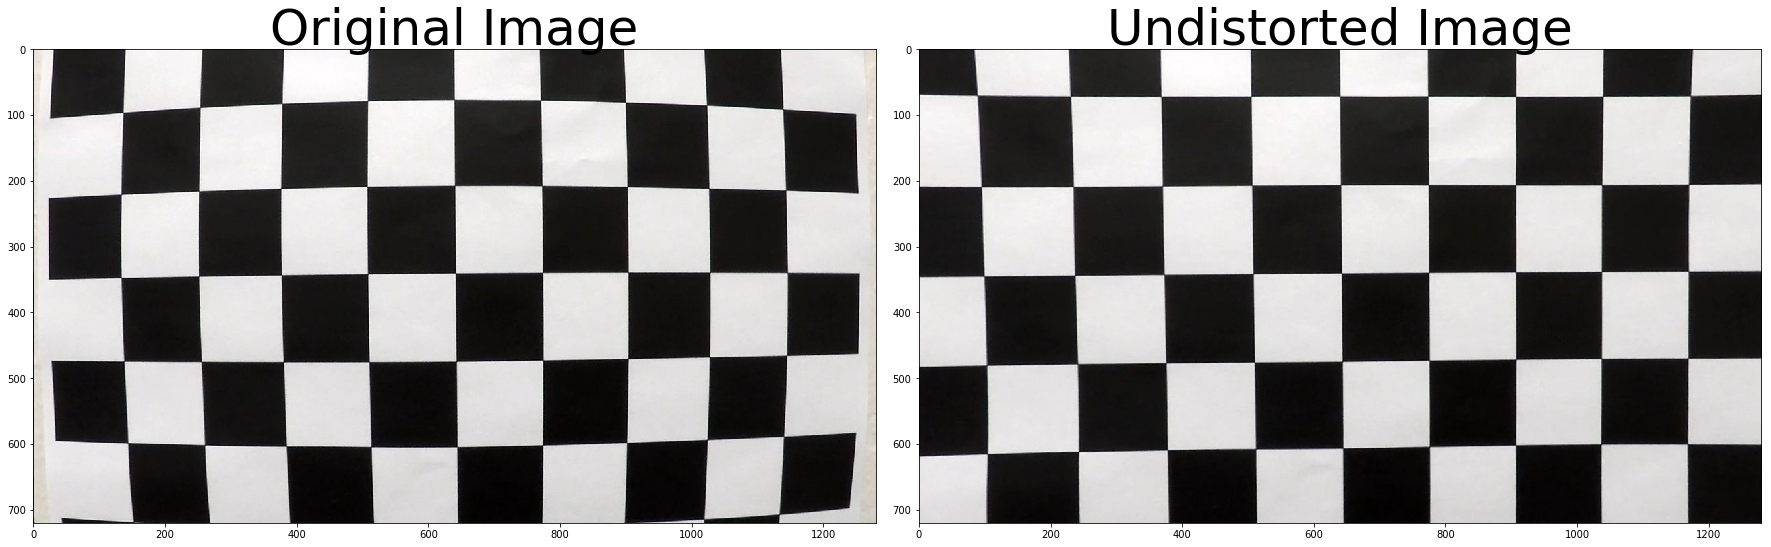

In [4]:
import glob
# %matplotlib qt

# Read in adn make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Arrays to store object points and image points from all the images
objpoints = []
imgpoints = []

# Prepare object points
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

for fname in images:
    # Read in each image
    img = mpimg.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)

# performs the camera calibration, image distortion correction and 
# returns the undistorted image      
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    # dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Undistorting a test image
test_img = mpimg.imread('./camera_cal/calibration1.jpg')
undistorted = cal_undistort(test_img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/undistorted.jpg", undistorted)

## Abs Sobel Thresh

True

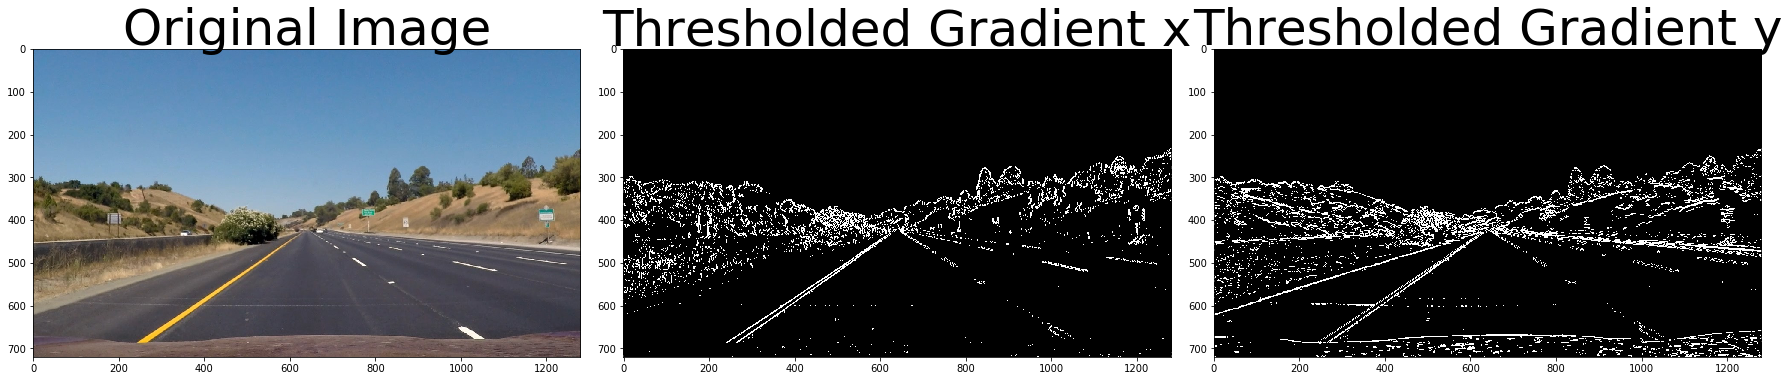

In [5]:
# Read in an image and grayscale it
image = mpimg.imread('./test_images/straight_lines1.jpg')


# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Run the function
grad_binary_x = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)
grad_binary_y = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=100)
# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary_x, cmap='gray')
ax2.set_title('Thresholded Gradient x', fontsize=50)
ax3.imshow(grad_binary_y, cmap='gray')
ax3.set_title('Thresholded Gradient y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/thresholded_gradient_x.jpg", grad_binary_x * 255)
cv2.imwrite("output_images/thresholded_gradient_y.jpg", grad_binary_y * 255)

## Magnitude of Gradient

True

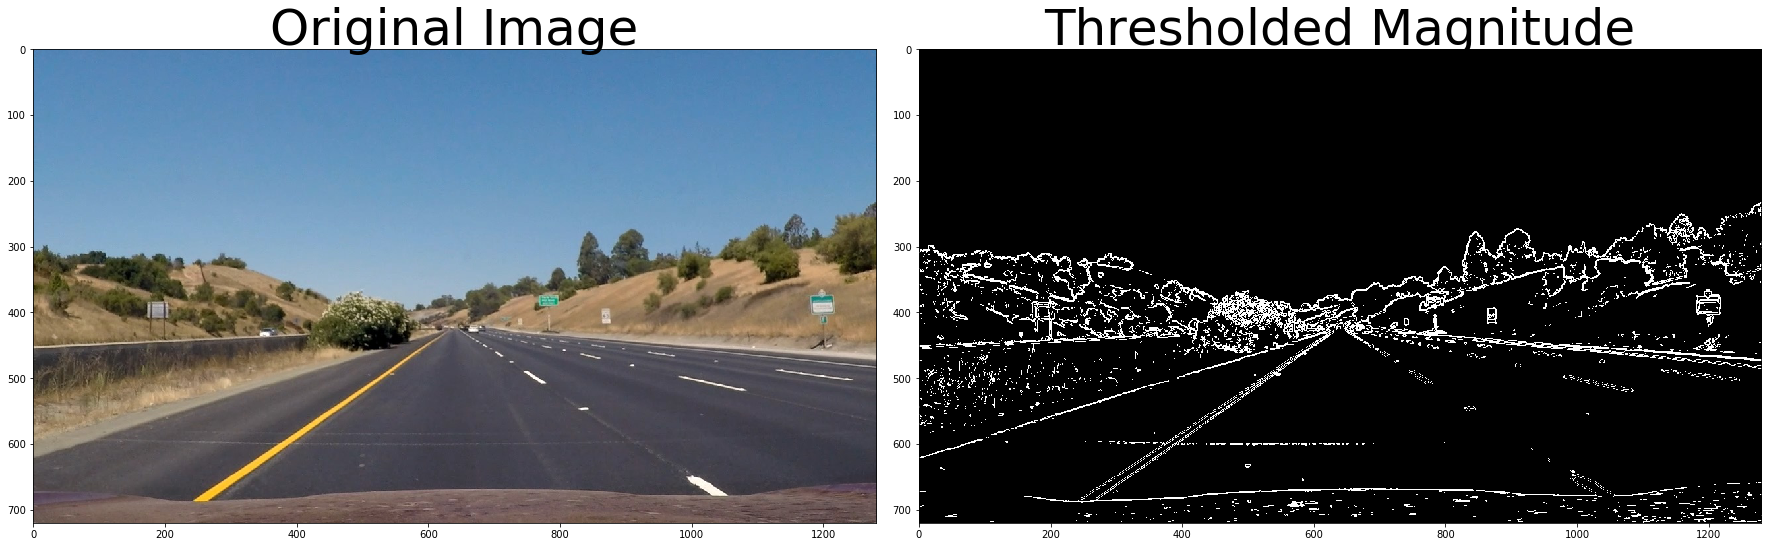

In [6]:

# Read in an image
image = mpimg.imread('./test_images/straight_lines1.jpg')

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


cv2.imwrite("output_images/thresholded_magnitude.jpg", mag_binary * 255)


## Direction of Gradient

True

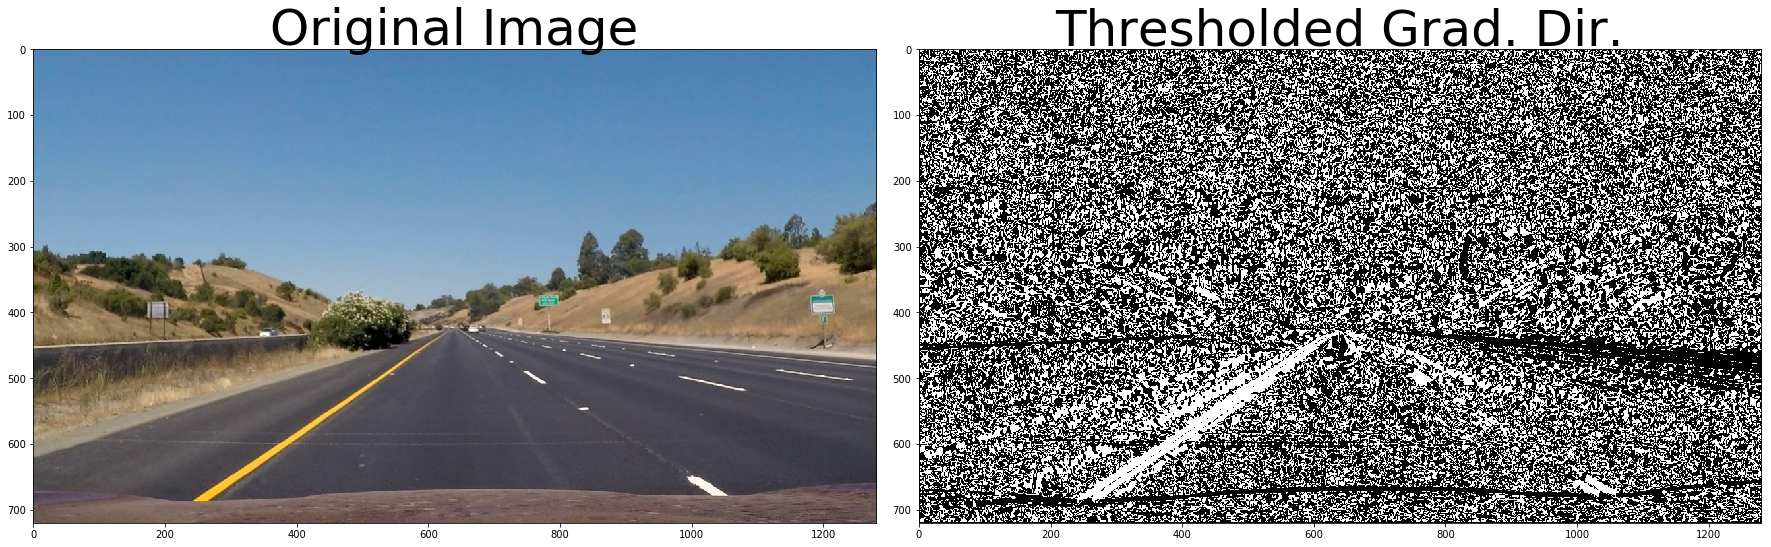

In [7]:

# Read in an image
image = mpimg.imread('./test_images/straight_lines1.jpg')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gradient)
    
    # 6) Return this mask as your binary_output image
    binary_output[(dir_gradient > thresh[0]) & (dir_gradient < thresh[1])] = 1
    # binary_output = np.copy(img) # Remove this line
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/thresholded_dir_gradient.jpg", dir_binary * 255)


## Combining Thresholds

True

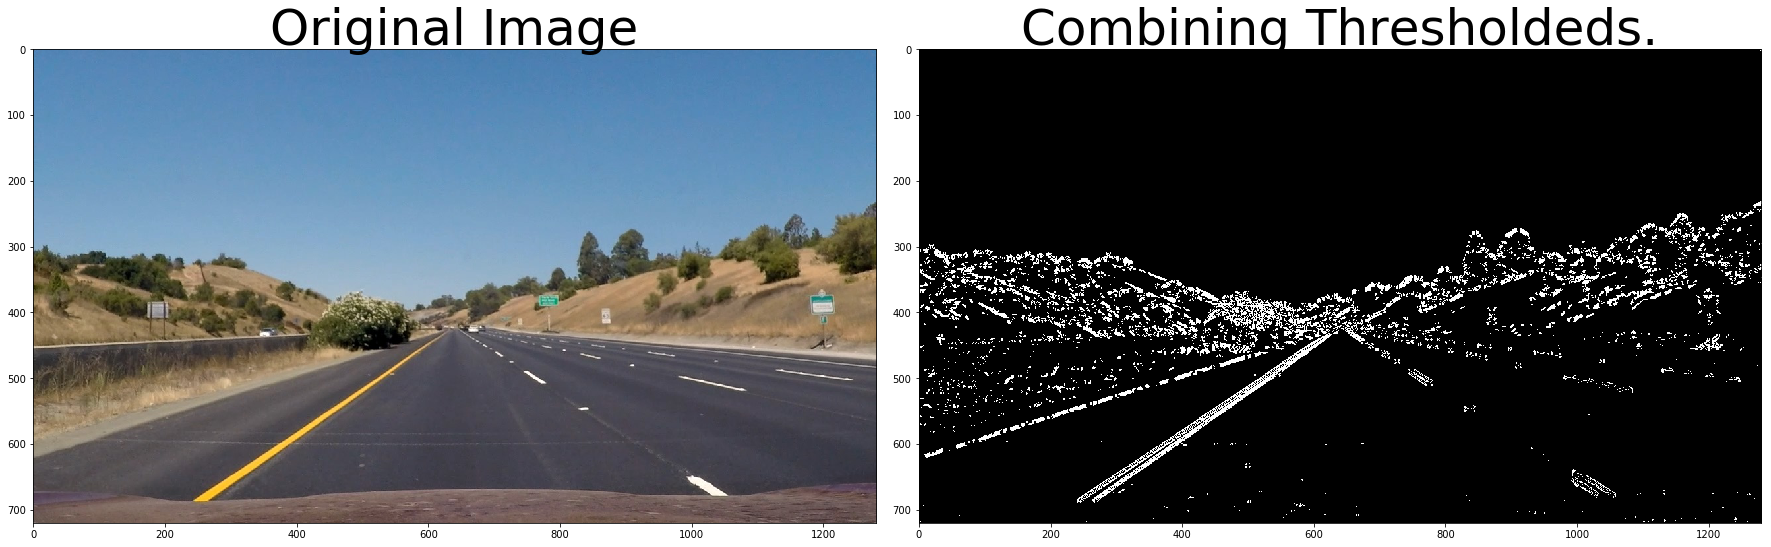

In [8]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    # Apply threshold
    return binary_output
#     return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    # Apply threshold
    return binary_output
#     return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_gradient = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_gradient)
    
    # 6) Return this mask as your binary_output image
    binary_output[(dir_gradient > thresh[0]) & (dir_gradient < thresh[1])] = 1
    # binary_output = np.copy(img) # Remove this line
    # Apply threshold
    return binary_output
#     return dir_binary




# Read in an image
image = mpimg.imread('./test_images/straight_lines1.jpg')

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))


combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combining Thresholdeds.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


cv2.imwrite("output_images/combined_grad_mag_dir.jpg", combined * 255)


## Color Space, HLS and Color Thresholds

True

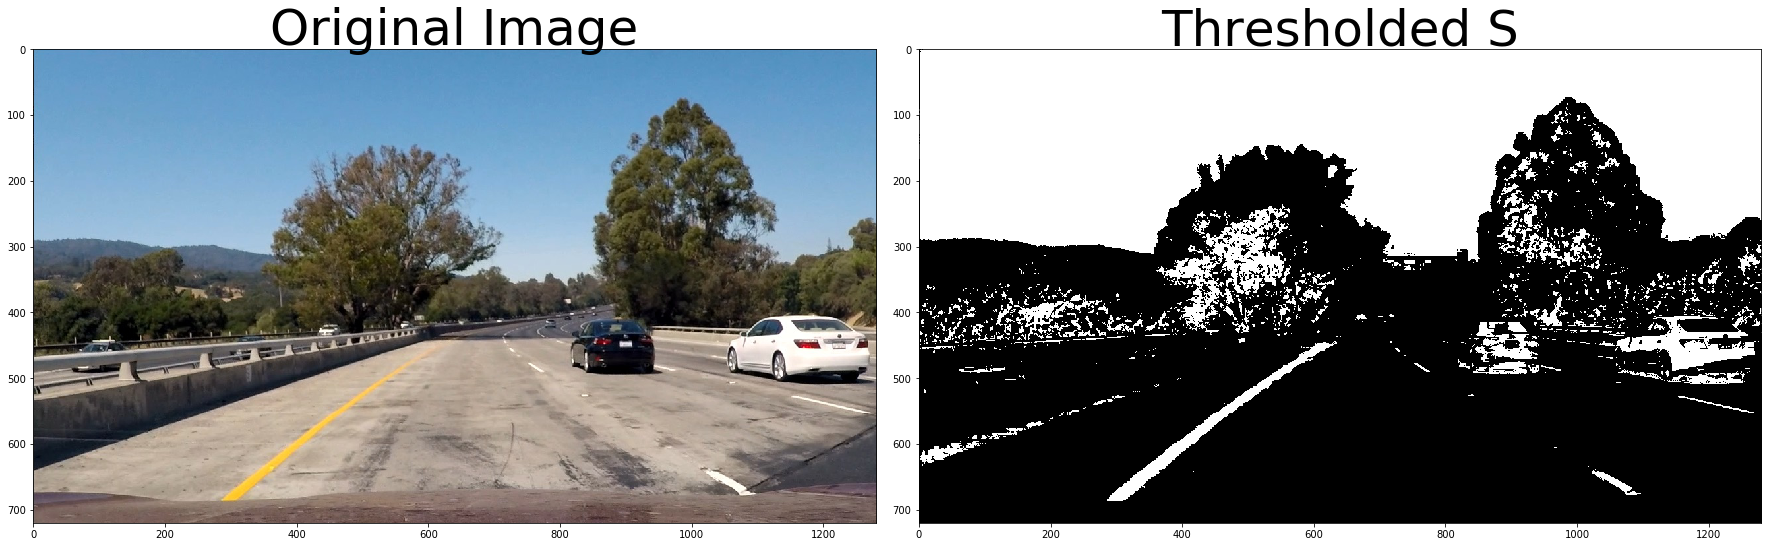

In [9]:
# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('./test_images/straight_lines1.jpg') 
image = mpimg.imread('./test_images/test1.jpg') 

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(s)
    binary_output[(s > thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    # binary_output = np.copy(img) # placeholder line
    return binary_output
    
hls_binary = hls_select(image, thresh=(90, 255))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/thresholded_S.jpg", hls_binary * 255)


Color and Gradient

True

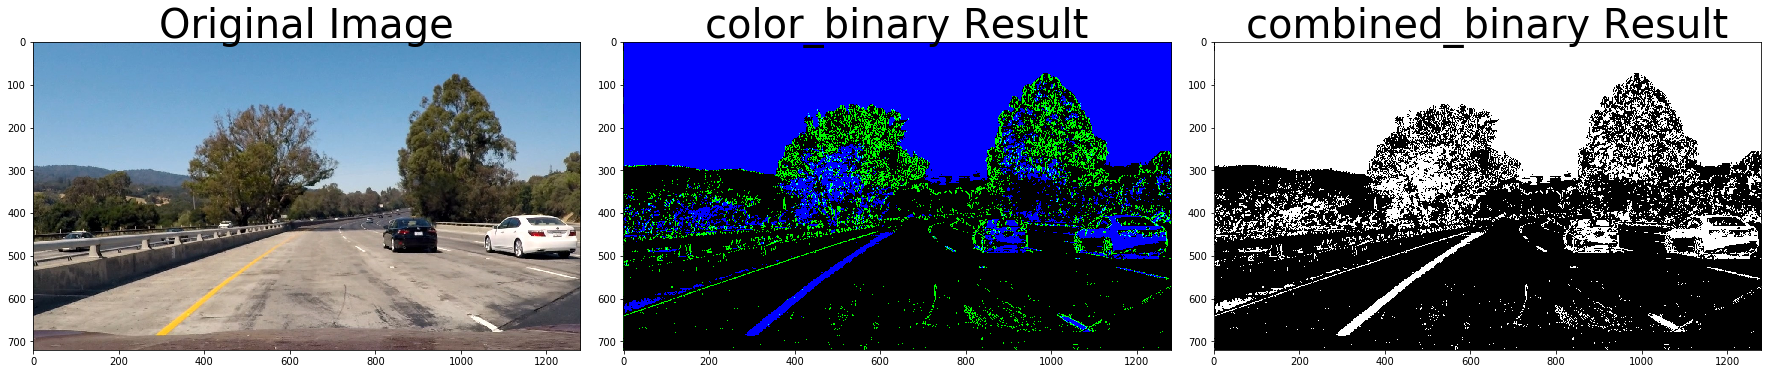

In [10]:

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return color_binary, combined_binary



# Read an image
image = mpimg.imread('./test_images/straight_lines1.jpg')
image = mpimg.imread('./test_images/test1.jpg')

color_binary, combined_binary = pipeline(image, s_thresh=(90, 255), sx_thresh=(20, 100))

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(color_binary)
ax2.set_title('color_binary Result', fontsize=40)

ax3.imshow(combined_binary, cmap='gray')
ax3.set_title('combined_binary Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


cv2.imwrite("output_images/combined_S_gradient.jpg", combined_binary * 255)


1. Camera calibration
2. Distortion correction
3. Color/gradient threshold
4. Perspective transform
5. Detect lane lines
6. Determine the lane curvature

1. compute the camera calibration matrix and distortion coefficients. (once is ok)
2. use them to undistort each new frame
3. apply thresholds to create a binary image
4. apply a perspective transform


True

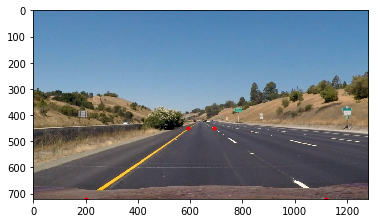

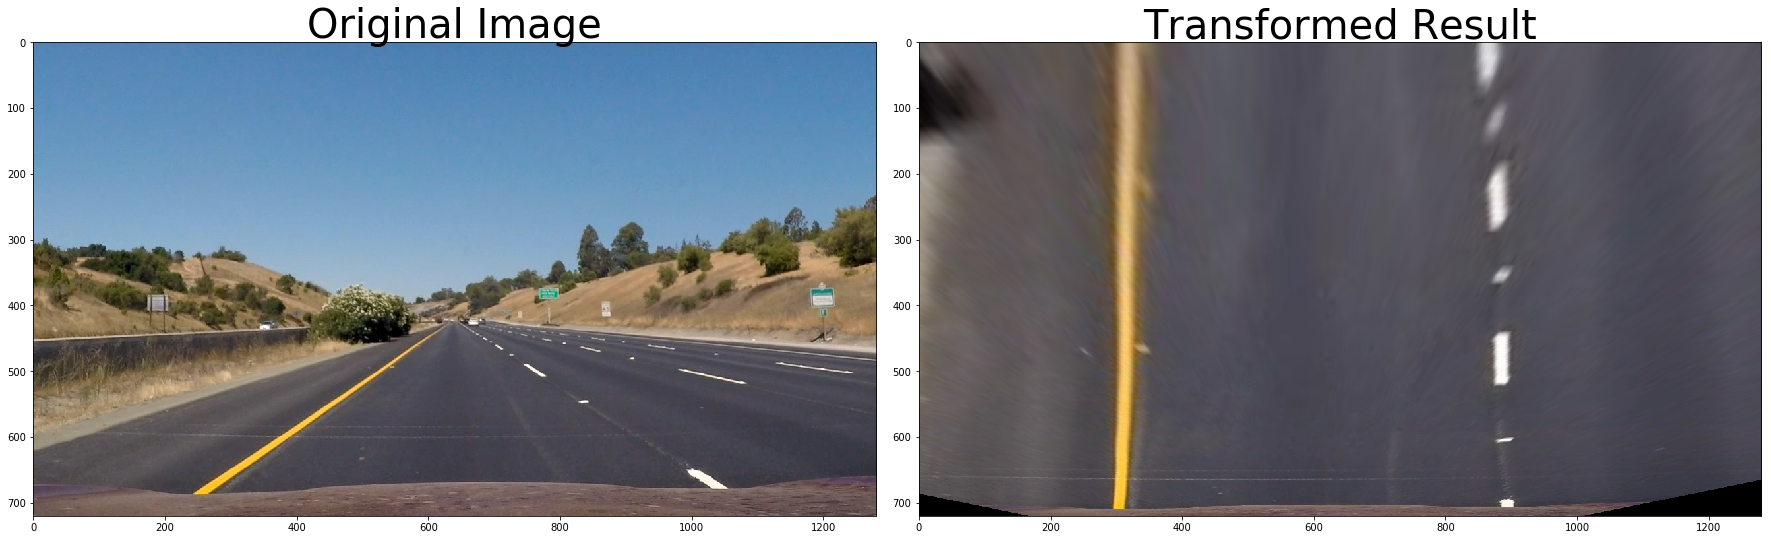

In [11]:

# Read an image
image = mpimg.imread('./test_images/straight_lines1.jpg')
plt.imshow(image)

plt.plot(593, 450, 'r.')
plt.plot(690, 450, 'r.')
plt.plot(200, 720, 'r.')
plt.plot(1120, 720, 'r.')


def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinate
    src = np.float32([
        [593, 450],
        [690, 450],
        [200, 720],
        [1120, 720]
    ])
    
    # Four desired coordinates
    dst = np.float32([
        [300, 0],
        [900, 0],
        [300, 720],
        [900, 720]
    ])
    
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(src, dst)
    
    # Create warped image - use linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

warped_im = warp(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_im)
ax2.set_title('Transformed Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/top_down_view.jpg", warped_im)


## Transform the thresholded binary image

1. First transform the straight line image
2. Second transform the curved line image

True

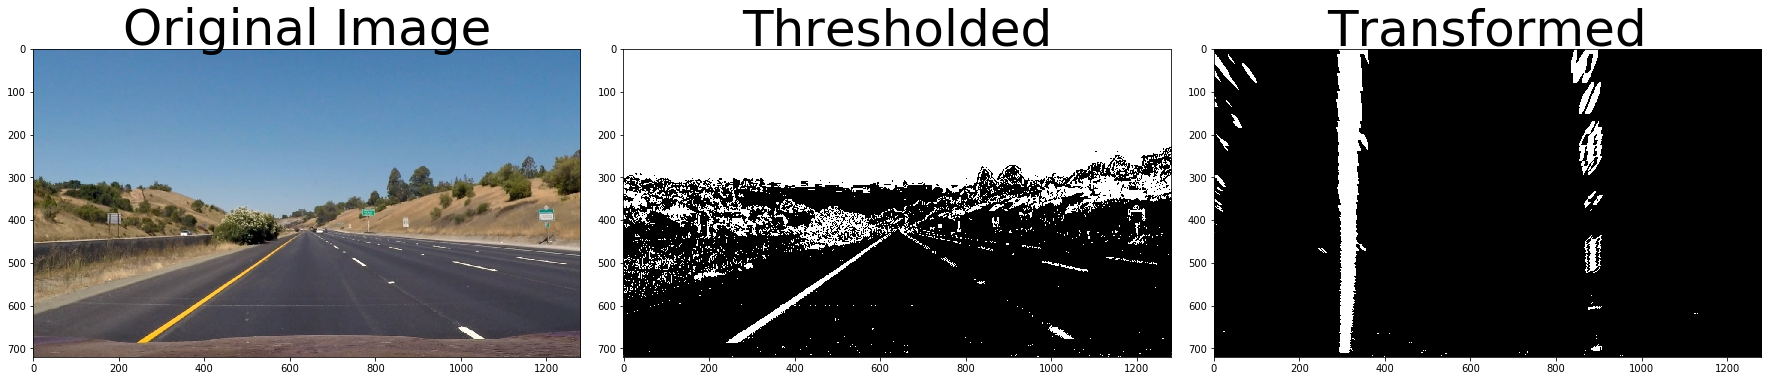

In [12]:

# Read an image
image = mpimg.imread('./test_images/straight_lines1.jpg')

c_b, thresholded_binary = pipeline(image, s_thresh=(90, 255), sx_thresh=(20, 100))
warped_thresholded_binary = warp(thresholded_binary)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_binary, cmap='gray')
ax2.set_title('Thresholded', fontsize=50)
ax3.imshow(warped_thresholded_binary, cmap='gray')
ax3.set_title('Transformed', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/top_down_view_binary.jpg", warped_thresholded_binary*255)


True

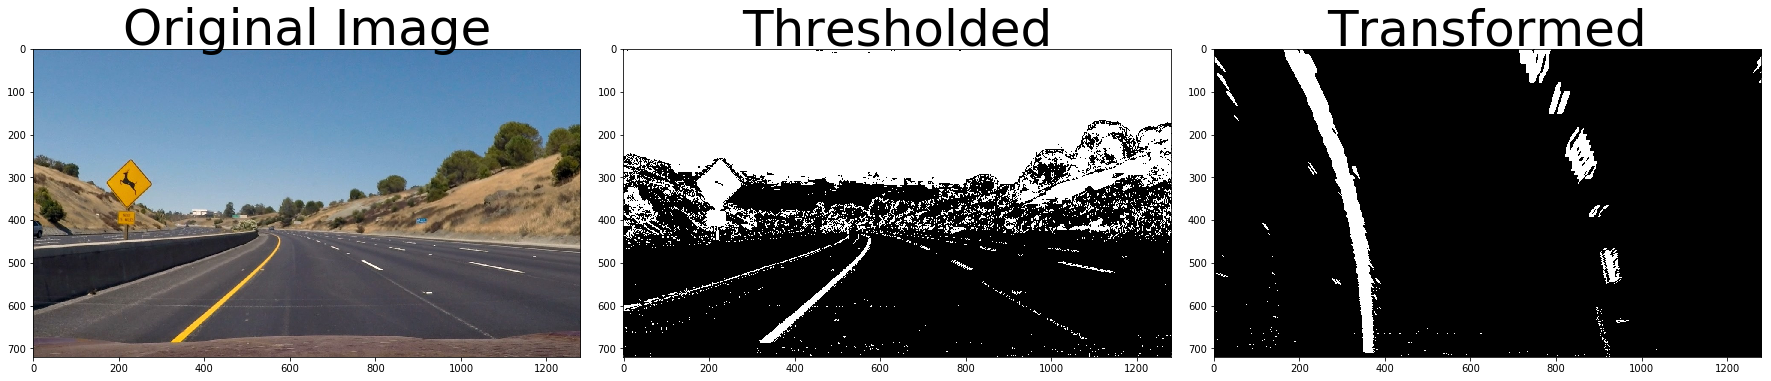

In [13]:
# Read an image
image = mpimg.imread('./test_images/test2.jpg')
# undistorted = cal_undistort(image, objpoints, imgpoints)
# plt.imshow(undistorted)
c_b, thresholded_binary = pipeline(image, s_thresh=(90, 255), sx_thresh=(20, 100))
warped_thresholded_binary = warp(thresholded_binary)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(thresholded_binary, cmap='gray')
ax2.set_title('Thresholded', fontsize=50)
ax3.imshow(warped_thresholded_binary, cmap='gray')
ax3.set_title('Transformed', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite("output_images/top_down_view_binary2.jpg", warped_thresholded_binary*255)


## Use the Histogram peaks to find the lane lines position.

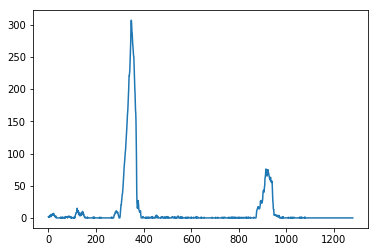

In [14]:
# Load our image
image = mpimg.imread('./test_images/test2.jpg')
c_b, thresholded_binary = pipeline(image, s_thresh=(90, 255), sx_thresh=(20, 100))
warped_thresholded_binary = warp(thresholded_binary)

def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
      
    return histogram

# Create histogram of image binary activations

histogram = hist(warped_thresholded_binary)

# Visualize the resulting histogram
plt.plot(histogram)

In [15]:
def binary_warped_generate(image):
    c_b, thresholded_binary = pipeline(image, s_thresh=(90, 255), sx_thresh=(20, 100))
    warped_thresholded_binary = warp(thresholded_binary)
    return warped_thresholded_binary

image = mpimg.imread('./test_images/test2.jpg')
binary_warped = binary_warped_generate(image)

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

print(leftx_base, rightx_base)

348 914


## Set up windows and window hyperparameters

True

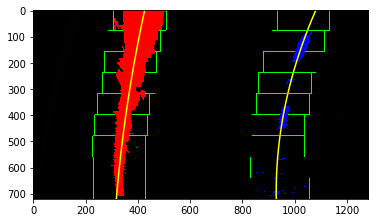

In [16]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

def binary_warped_generate(image):
    c_b, thresholded_binary = pipeline(image, s_thresh=(90, 255), sx_thresh=(20, 100))
    warped_thresholded_binary = warp(thresholded_binary)
    return warped_thresholded_binary

image = mpimg.imread('./test_images/test1.jpg')
binary_warped = binary_warped_generate(image)
out_img = fit_polynomial(binary_warped)

plt.imshow(out_img)

cv2.imwrite("output_images/sliding_window.jpg", out_img)


## Search around last fit params. Measure the curve radius.

2541.89866518 1406.1662256


True

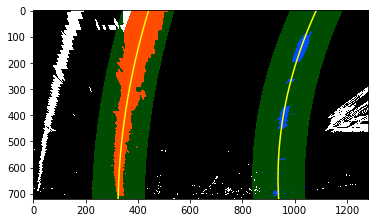

In [17]:
# Load our image - this should be a new frame since last time!
# binary_warped = mpimg.imread('warped_example.jpg')

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
     
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
   
    return result, left_curverad, right_curverad

image = mpimg.imread('./test_images/test1.jpg')
binary_warped = binary_warped_generate(image)

# out_img = fit_polynomial(binary_warped)
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_curverad, right_curverad = search_around_poly(binary_warped, left_fit, right_fit)
print(left_curverad, right_curverad)

# View your output
plt.imshow(result)

cv2.imwrite("output_images/lane_lines.jpg", result)


## Measure the curve radius in the real world.

curve in pixel:  2541.89866518 1406.1662256
curve in real world(m):  834.385258265 459.629315845


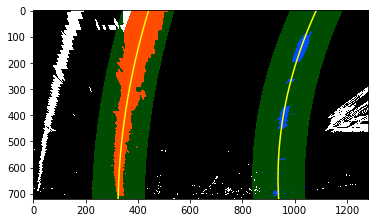

In [18]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
 
    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    # Fit new polynomials (in the real world)
    left_fit_cr, right_fit_cr, left_fitx_cr, right_fitx_cr, ploty_cr = fit_poly(binary_warped.shape,
                        leftx * xm_per_pix, 
                        lefty * ym_per_pix,
                        rightx * xm_per_pix, 
                        righty * ym_per_pix)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # Calculation of R_curve (radius of curvature in the real world)
    left_curverad_real = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_real = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
   
    return result, left_curverad, right_curverad, left_curverad_real, right_curverad_real


image = mpimg.imread('./test_images/test1.jpg')
binary_warped = binary_warped_generate(image)

# out_img = fit_polynomial(binary_warped)
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result, left_curverad, right_curverad, left_curverad_real, right_curverad_real = search_around_poly(binary_warped, left_fit, right_fit)
print("curve in pixel: ",left_curverad, right_curverad)
print("curve in real world(m): ",left_curverad_real, right_curverad_real)

# View your output
plt.imshow(result)    

# # Calculate the radius of curvature in meters for both lane lines
# left_curverad, right_curverad = measure_curvature_real()

# print(left_curverad, 'm', right_curverad, 'm')
# # Should see values of 533.75 and 648.16 here, if using
# # the default `generate_data` function with given seed number